# Exercises Week 5 in 02506

This week we will dive into Markow Random Fields
<p align="center"> 
  <img src="images/DTU_noisy.PNG" width="300" title="Noisy DTU logo">
</p>

## Imports

In [3]:
import numpy as np
from skimage.io import imread, imshow, imsave
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from skimage import color
import cv2
import scipy.ndimage
import matplotlib.pyplot as plt
import maxflow

## MRF Modelling
### 1. Get hold of the gray-scale image D and one configuration for the segmentation S. To begin with, this may be a ground truth segmentation. Notice that a ground truth segmentation (labeling) is not the same as a noise-free image: elements of the segmentation are labels 1, 2, . . . while elements of the noise-free image are pixel intensities $\mu_1,\mu_2,\ldots$

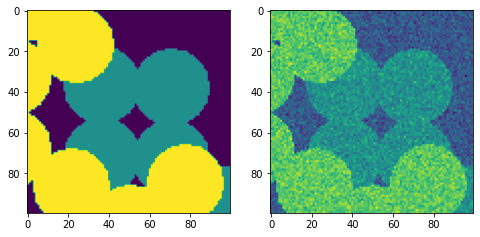

In [4]:
S = imread('./images/noise_free_circles.png')
D = imread('./images/noisy_circles.png')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.imshow(S)
ax2.imshow(D)

### 2. For computing V1 you need D, S and m. First, compute an intensityrealization of S, that is an image where each occurrence of label i is replaced by $\mu_i$. It is then easy to compute V1 as a sum of squared differences.

### 3. For computing V2 you need S and b. Recall that an almost identical problem was solved in week 1.

In [5]:
def boundary_length(S):
    lx = S[1:,:]!=S[:-1,:]
    ly = S[:,1:]!=S[:,:-1]
    L = np.sum(lx)+np.sum(ly)
    return L


def segmentation_energy(S, I, mu, beta):
    # TODO -- add your code here
    Iflat = I.flatten()
    Sflat = S.flatten()
    # likelihood energy
    U1 = np.sum([(mu[f]-d)**2 for d,f in zip(Iflat,Sflat)])
    
    # prior energy
    U2 = beta*boundary_length(S)
    
    return(U1,U2)

def segmentation_histogram(ax, I, S, edges=None):
    '''
    Histogram for data and each segmentation label.
    '''
    if edges is None:
        edges = np.linspace(I.min(), I.max(), 100)
    ax.hist(I.ravel(), bins=edges, color = 'k')
    centers = 0.5*(edges[:-1] + edges[1:]);
    for k in range(S.max()+1):
        ax.plot(centers, np.histogram(I[S==k].ravel(), edges)[0])
        

/tmp/ipykernel_633/778915887.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  I = imread(path + 'noisy_circles.png').astype(np.float)
/home/antonrydahl/anaconda3/envs/image_analysis/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


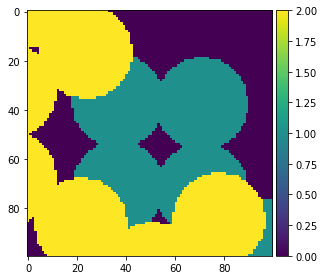

In [6]:
path = 'images/'
I = imread(path + 'noisy_circles.png').astype(np.float)

segmentations = [] # list where I'll place different segmentations
GT = imread(path + 'noise_free_circles.png')

(mu, S_gt) = np.unique(GT, return_inverse=True)
S_gt = S_gt.reshape(I.shape)

segmentations += [S_gt]

imshow(S_gt)

### 4. Produce some other configurations S, by any means you find appropriate: thresholding, manually drawing, modifying ground truth. . . Apply your two functions to all configurations, and display the likelihood, prior and posterior for every configuration.

In [7]:
S_t = np.zeros(I.shape, dtype=int) + (I>100) + (I>160) # thresholded
segmentations += [S_t]

D_s = scipy.ndimage.gaussian_filter(I, sigma=1, truncate=3, mode='nearest')
S_g = np.zeros(I.shape, dtype=int) + (D_s>100) + (D_s>160) # thresholded
segmentations += [S_g]

D_m = scipy.ndimage.median_filter(I, size=(5,5), mode='reflect');
S_t = np.zeros(I.shape, dtype=int) + (D_m>100) + (D_m>160) # thresholded
segmentations += [S_t]

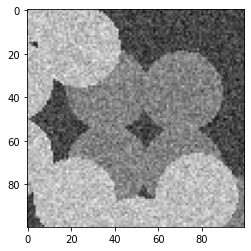

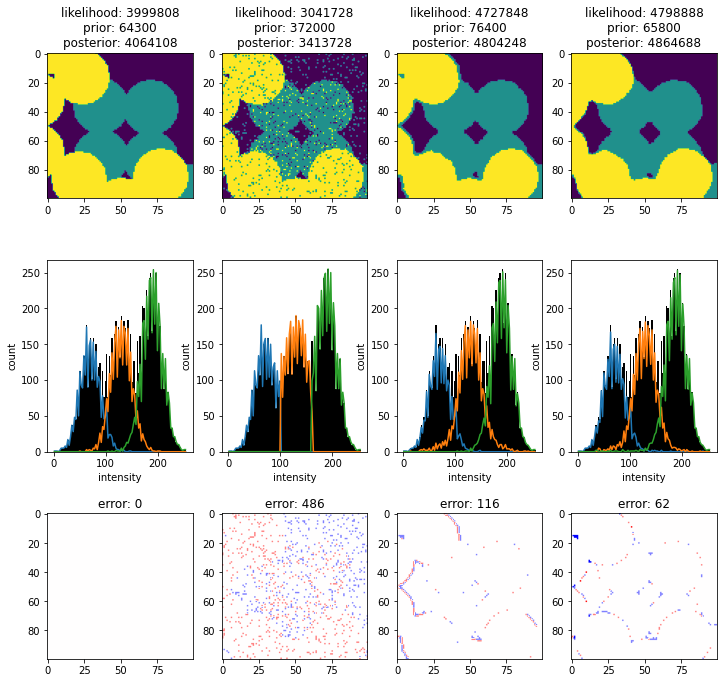

In [8]:
fig, ax = plt.subplots()
ax.imshow(I, vmin=0, vmax=255, cmap=plt.cm.gray)


N = len(segmentations)
fig, ax = plt.subplots(3,N,figsize=(12,12))
beta = 100

for i in range(N):
    ax[0][i].imshow(segmentations[i])
    V1, V2 = segmentation_energy(segmentations[i], I, mu, beta)
    ax[0][i].set_title(f'likelihood: {int(V1)}\nprior: {V2}\nposterior: {int(V1+V2)}')
    
    segmentation_histogram(ax[1][i], I, segmentations[i])
    ax[1][i].set_xlabel('intensity')
    ax[1][i].set_ylabel('count')
    
    err = S_gt - segmentations[i]
    ax[2][i].imshow(err, vmin=-2, vmax=2, cmap=plt.cm.bwr)
    ax[2][i].set_title(f'error: {(err>0).sum()}')

### 5. If we consider only the likelihood, which configuration is the most probable? If we consider only the prior energy, which configuration is the most probable? What if we consider the posterior energy?
The prior energy perhaps seems like the best indicator for now, since the prior is smallest for the first segmentation which is in fact the ground truth. 

## Graph cuts for optimizing MRF
1. Install the required maxflow package (python) for graph cuts and/or
download the provided software (MATLAB).
2. Get a small scripts which solves the gender labeling problem.
3. Run the script and get familiar with the functionality of your graphcut
solver.
4. Which configuration is optimal? Change b = 10 and solve again.
Which configuration is optimal now? Try also b = 1000.

In [9]:
d = np.array([179, 174, 182, 162, 175, 165]) # heights (data)
mu = [181, 165] # means of two classes
beta = 10 # weight of the prior term
w_s = (d-mu[0])**2 # source weight
w_t = (d-mu[1])**2 # sink weights
N = len(d) # number of graph nodes

# Create a graph with integer capacities.
g = maxflow.Graph[int]()
# Add (non-terminal) nodes and retrieve an index for each node
nodes = g.add_nodes(N)
# Create edges between nodes
for i in range(N-1):
    g.add_edge(nodes[i], nodes[i+1], beta, beta)
# Set the capacities of the terminal edges.
for i in range(N):
    g.add_tedge(nodes[i], (d[i]-mu[1])**2, (d[i]-mu[0])**2)
# Run the max flow algorithm
flow = g.maxflow()
print(f'Maximum flow: {flow}')

# displaying the results
labeling = [g.get_segment(nodes[i]) for i in range(N)]
gend = 'MF'

for i in range(0,N):
    print(f'Person {i} is estimated as {gend[labeling[i]]}') 


Maximum flow: 129
Person 0 is estimated as M
Person 1 is estimated as M
Person 2 is estimated as M
Person 3 is estimated as F
Person 4 is estimated as M
Person 5 is estimated as F


### Quiz

In [10]:
img = np.array([[1, 2, 6, 4, 10, 8],[4, 1, 3, 5, 9, 6],[5, 2, 3, 5, 4, 7]])
mu1 = 2
mu2 = 5
mu3 = 10
beta = 10

## 5.4 Binary segmentation using MRF

### 1. The DTU logo is of type uint8 and should be converted into double precision (float) before any computation. You also want to divide image intensities with 255, as this will simplify the weighting between the likelihood and the prior term.

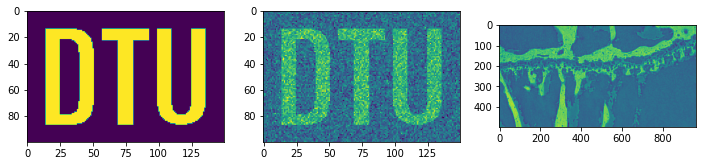

In [11]:
S = imread('./images/DTU.png')
D = imread('./images/DTU_noisy.png').astype(float)/255.0
D2 = imread('./images/V12_10X_x502.png').astype(float)/255.0

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
ax1.imshow(S)
ax2.imshow(D)
ax3.imshow(D2)

### 2. For the DTU logo use m1 = 90/255 and m2 = 170/255.

In [12]:
mu1 = 90.0/255.0
mu2 = 170.0/255.0

### 3. To pass the weights of terminal and internal edges to graph solver, python users may use the functionality provided by maxflow, see the example Binary image restoration but notice that it uses a different energy formulation.

### 4. For the DTU logo, choose parameter b which yields in a good segmentation.

Text(0.5, 1.0, 'Reconstruction using beta=0.1')

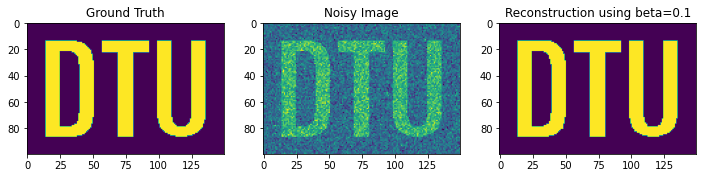

In [13]:
beta = 0.1

# Create the graph.
g = maxflow.Graph[float]()

nodeids = g.add_grid_nodes(D.shape)

g.add_grid_edges(nodeids, beta)

# Adding the likelihood, that is V1
V1_mu1 = np.square((D-mu1))
V1_mu2 = np.square((D-mu2))
g.add_grid_tedges(nodeids,V1_mu1,V1_mu2)

g.maxflow()

sgm = g.get_grid_segments(nodeids)

recon = np.int_(np.logical_not(sgm))

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
ax1.imshow(S)
ax1.set_title("Ground Truth")
ax2.imshow(D)
ax2.set_title("Noisy Image")
ax3.imshow(recon)
ax3.set_title(f"Reconstruction using beta={beta}")

### 5. The bone image is of type uint16 and after converting it into double precision you may also want to divide image intensities with $2^{16}-1$.

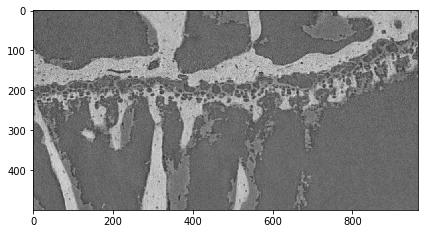

In [14]:
D2 = imread('./images/V12_10X_x502.png').astype(float)/(pow(2,16)-1)
imshow(D2)

### 6. For bone image, you need to determine the mean intensities of the air and bone ($\mu_1$ and $\mu_2$) by inspecting the histogram. 
Look at maximum likelihood configuration, to confirm that your m1 and m2 are suitable.
Choose a (small) parameter b and compute the optimal configuration
for this b using your graph cut solver. Then, adjust b to obtain a
visually pleasing segmentation with reduced noise in air and bone
choose. Observe how changing b affects the segmentation.

(array([[ 2., 12., 66., ..., 45.,  3.,  0.],
        [ 2., 20., 68., ..., 54.,  3.,  0.],
        [ 2.,  8., 86., ..., 55.,  7.,  0.],
        ...,
        [ 0., 10., 54., ..., 19.,  3.,  1.],
        [ 0., 11., 52., ..., 23.,  3.,  0.],
        [ 0., 12., 51., ..., 29.,  4.,  0.]]),
 array([0.14137484, 0.21715572, 0.2929366 , 0.36871748, 0.44449836,
        0.52027924, 0.59606012, 0.671841  , 0.74762188, 0.82340276,
        0.89918364]),
 <a list of 964 BarContainer objects>)

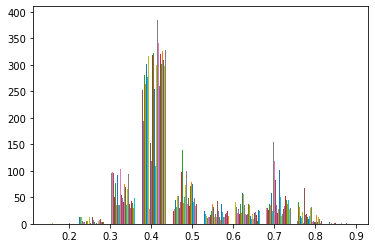

In [15]:
plt.hist(D2)

Text(0.5, 1.0, 'Reconstruction using beta=0.05')

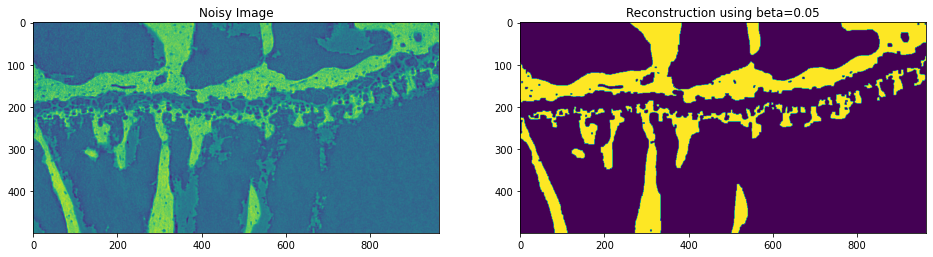

In [16]:
mu1 = 0.42
mu2 = 0.7
beta = 0.05

# Create the graph.
g = maxflow.Graph[float]()

nodeids = g.add_grid_nodes(D2.shape)

g.add_grid_edges(nodeids, beta)

# Adding the likelihood, that is V1
V1_mu1 = np.square((D2-mu1))
V1_mu2 = np.square((D2-mu2))
g.add_grid_tedges(nodeids,V1_mu1,V1_mu2)

g.maxflow()

sgm = g.get_grid_segments(nodeids)

recon = np.int_(np.logical_not(sgm))

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.imshow(D2)
ax1.set_title("Noisy Image")
ax2.imshow(recon)
ax2.set_title(f"Reconstruction using beta={beta}")

## Quiz

### 1. What is the prior energy of the maximum likelihood solution?
We consider and image which is to be segmented into three segments: 1, 2 and 3. The segments are estimated
to have mean intensities $\mu_1 = 2,\mu_2 = 5$ and $\mu_3 = 10$. We use an MRF framework as
in the lecture note, and we choose to set $\beta = 10$.

In [28]:
img =  np.array([[1, 2, 6, 4, 10, 8],
        [4, 1, 3, 5, 9, 6],
        [5, 2, 3, 5, 4, 7]])
mu = [2,5,10]
beta = 10

In [36]:
from maxflow.fastmin import aexpansion_grid

mu = [0.42,0.55,0.7]
beta = 0.05

# Loading image
I = imread('./images/V12_10X_x502.png').astype(float)/(pow(2,16)-1)
M,N = np.shape(I)
print(f"(m,n)=({M},{N})")
L = 3

# Making distance matrix
D = np.zeros(M,N,L)
for i in range(L):
    D[:,:,i] = np.square((D2-mu[i]))

# Generate nearest prototype labeling
Id = np.argmin(D,2)

fg = plt.figure("Direct labeling")
ax1 = fg.add_subplot(1,1,1)
ax1.imshow(Id)

# Calculate neighbourhood cost as absolute difference between prototypes 
alpha = 1.6
V = alpha * np.abs( levs.reshape((-1,1)) - levs.reshape((1,-1)))

# Mimimise data + neighbourhood cost
labels = aexpansion_grid(D,V)

fg = plt.figure("Regularised labeling")
ax1 = fg.add_subplot(1,1,1)
ax1.imshow(labels)

(m,n)=(500,964)


/tmp/ipykernel_633/1532583535.py:11: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  D = np.zeros(None)


AxisError: axis 2 is out of bounds for array of dimension 1

### 2. What is the likelihood energy of the configuration where the leftmost two columns are labeled as belonging to the segment 1, middle two columns are labeled as belonging to the segment 2, and rightmost two colums are labeled as belonging to the segment 3?

In [29]:
segmentation = np.array([[0, 0, 1, 1, 2, 2],
                [0, 0, 1, 1, 2, 2],
                [0, 0, 1, 1, 2, 2]])
V1, V2 = segmentation_energy(segmentation, img, mu, beta)
print(f'likelihood: {int(V1)}\nprior: {V2}\nposterior: {int(V1+V2)}')

likelihood: 91
prior: 60
posterior: 151


### 3. What is the posterior energy of the maximum a posteriory solution? (Write the smallest energy, which you could find.)